In [268]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import math

In [269]:
# 하버사인 거리 계산 함수
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # 지구 반지름 (km)
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])  # 라디안 변환
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return R * c

In [270]:
# CSV 파일 로드
file_path = "./data/train.csv"
df = pd.read_csv(file_path)

In [271]:
df['fare_amount'].describe()

count    50000.000000
mean        11.364171
std          9.685557
min         -5.000000
25%          6.000000
50%          8.500000
75%         12.500000
max        200.000000
Name: fare_amount, dtype: float64

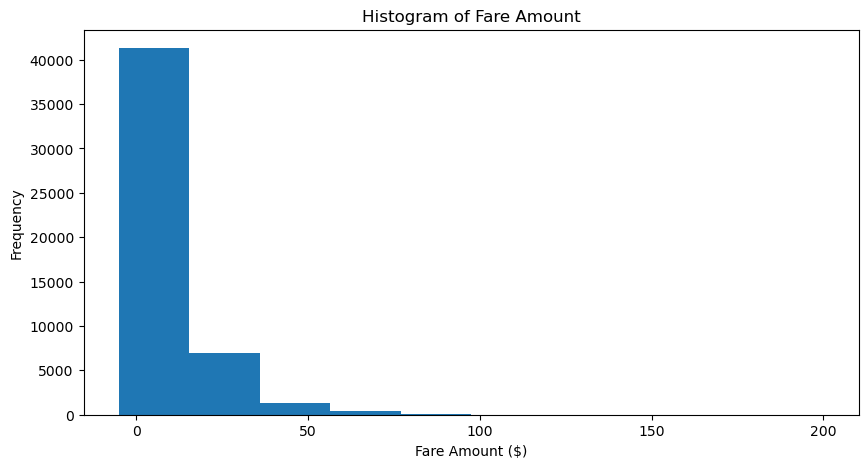

In [272]:
# 요금(fare_amount) 분포 히스토그램
plt.figure(figsize=(10, 5))
plt.hist(df['fare_amount'])
plt.xlabel("Fare Amount ($)")
plt.ylabel("Frequency")
plt.title("Histogram of Fare Amount")
plt.show()

In [273]:
# Distance 컬럼 추가 (위도, 경도 활용)
df['harver_Distance'] = df.apply(lambda row: haversine(row['pickup_latitude'], row['pickup_longitude'], 
                                                 row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

df['harver_Distance'].describe()

count    50000.000000
mean        18.508946
std        355.564309
min          0.000000
25%          1.223146
50%          2.120114
75%          3.895570
max       8667.818812
Name: harver_Distance, dtype: float64

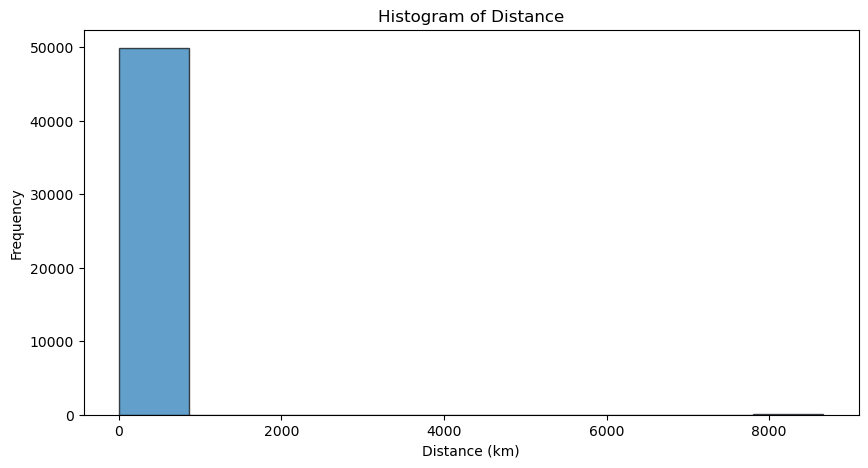

In [274]:
# 위경도계산거리(harver_Distance) 분포 히스토그램
plt.figure(figsize=(10, 5))
plt.hist(df['harver_Distance'], bins=10, edgecolor='black', alpha=0.7)
plt.xlabel("Distance (km)")
plt.ylabel("Frequency")
plt.title("Histogram of Distance")
plt.show()

In [275]:
# 이상치 제거 (운임 요금과 거리의 극단값 제거)
df = df[(df['fare_amount'] > 0) & (df['fare_amount'] < 100)]  # 0보다 크고 100보다 작은 요금금만 사용
df = df[df['harver_Distance'] < 25]  # 50km 이하의 거리만 사용

# 상관계수 확인
correlation = df[['harver_Distance', 'fare_amount']].corr()
print("상관계수:\n", correlation)

상관계수:
                  harver_Distance  fare_amount
harver_Distance         1.000000     0.859518
fare_amount             0.859518     1.000000


In [276]:
# 데이터 분할 (학습/테스트)
X = df[['harver_Distance']]
y = df['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scikit-learn 선형 회귀 모델
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# 회귀 계수 및 절편 출력
print(f"기울기 (Slope): {lin_reg.coef_[0]:.3f}")
print(f"절편 (Intercept): {lin_reg.intercept_:.3f}")

기울기 (Slope): 2.249
절편 (Intercept): 3.975


In [277]:
# 예측 수행
y_pred = lin_reg.predict(X_test)

# 모델 성능 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"평균 제곱 오차 (MSE): {mse:.2f}")
print(f"결정 계수 (R²): {r2:.3f}")

평균 제곱 오차 (MSE): 21.79
결정 계수 (R²): 0.755


In [278]:
# Statsmodels OLS 회귀 분석
X_train_sm = sm.add_constant(X_train)  # 상수 추가
ols_model = sm.OLS(y_train, X_train_sm).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                 1.103e+05
Date:                Wed, 19 Mar 2025   Prob (F-statistic):               0.00
Time:                        10:43:10   Log-Likelihood:            -1.1896e+05
No. Observations:               39864   AIC:                         2.379e+05
Df Residuals:                   39862   BIC:                         2.379e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               3.9746      0.033    1

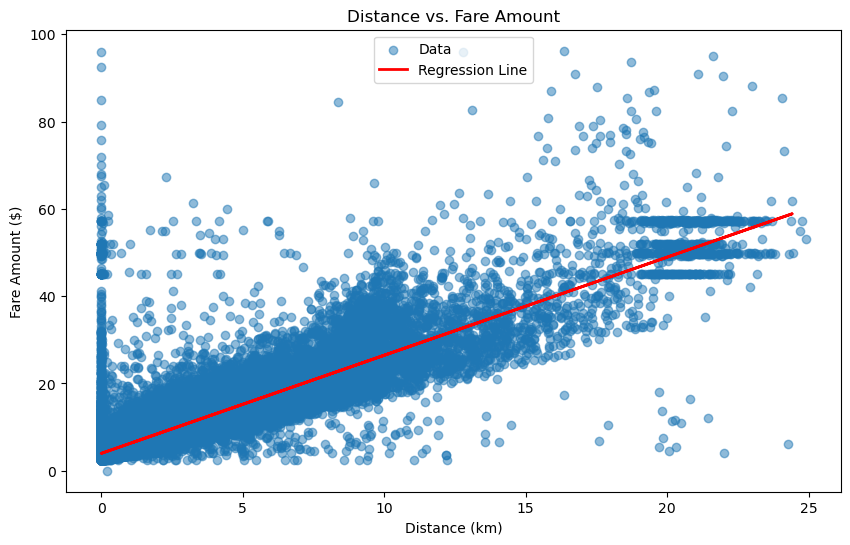

In [279]:
# 다양한 시각화 그래프 출력
plt.figure(figsize=(10, 6))
plt.scatter(df['harver_Distance'], df['fare_amount'], alpha=0.5, label="Data")
plt.plot(X_test, y_pred, color='red', linewidth=2, label="Regression Line")
plt.xlabel("Distance (km)")
plt.ylabel("Fare Amount ($)")
plt.title("Distance vs. Fare Amount")
plt.legend()
plt.show()

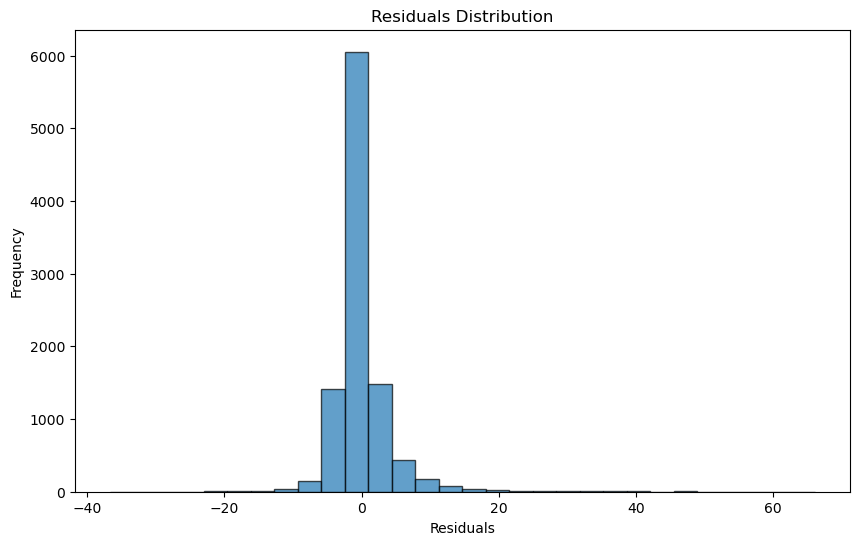

In [280]:
# 잔차 분석 그래프
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")
plt.show()

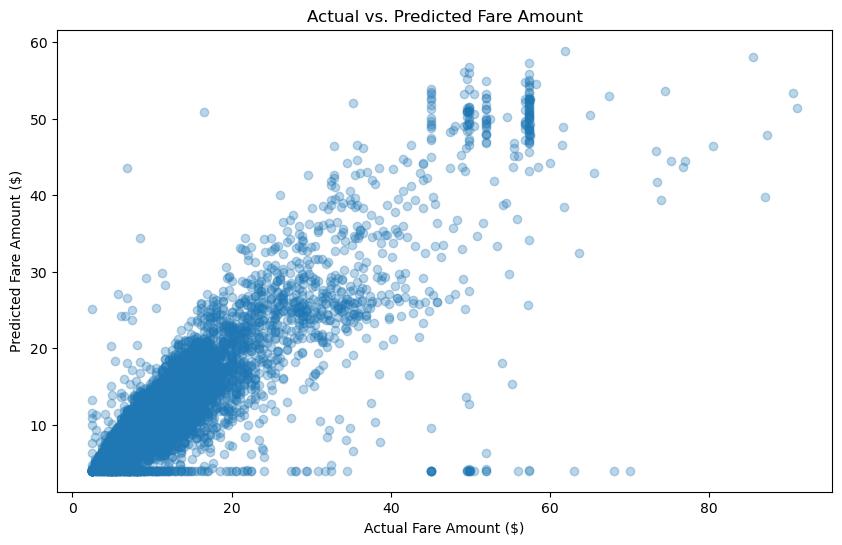

In [285]:
# 실제 값과 예측 값 비교
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Fare Amount ($)")
plt.ylabel("Predicted Fare Amount ($)")
plt.title("Actual vs. Predicted Fare Amount")
plt.show()

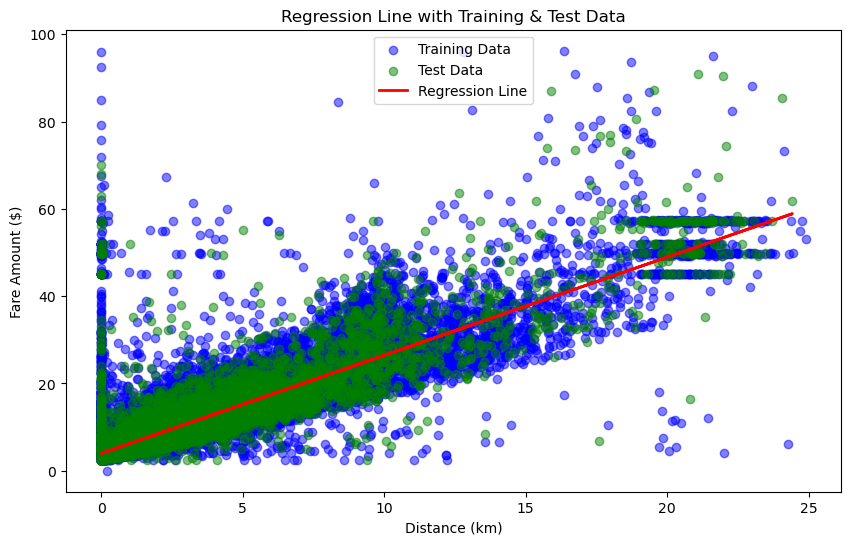

In [282]:
# 회귀선과 실제 데이터 분포 비교
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', label='Training Data', alpha=0.5)
plt.scatter(X_test, y_test, color='green', label='Test Data', alpha=0.5)
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Regression Line')
plt.xlabel("Distance (km)")
plt.ylabel("Fare Amount ($)")
plt.title("Regression Line with Training & Test Data")
plt.legend()
plt.show()